In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import os
import cv2

save_dir = os.path.join(os.getcwd(), 'saved_models')

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np

simpson_img = pd.read_csv('/data/examples/simpson_preproc/simpson_img_list.csv')
print(simpson_img.head())


  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg


(200, 200)

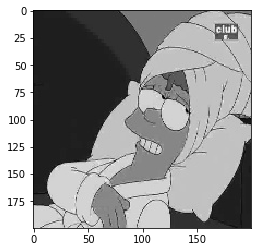

In [3]:
img = cv2.imread('/data/examples/simpson_preproc/' + simpson_img.img.iloc[0], 0)
plt.imshow(img, cmap="gray")
img.shape

In [4]:
simpson_img = simpson_img[simpson_img.img.str.contains('simpson')]
simpson_img.shape
# simpson_img.head(3)

(7274, 2)

# One-Hot Encoding the Classname

In [5]:
simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix()
# print(simpson_img['classname'])
# print(simpson_y)
print(simpson_y.shape)
num_classes = simpson_y.shape[1]


(7274, 6)


In [11]:
# can't handle this case due to the classname is not numeric
# num_classes = 6
# y_train = keras.utils.to_categorical(simpson_img['classname'], num_classes)

# load all the images becase we want to call Keras ImageGenerator
## currently I still have no idea aout how to use ImageGenerator with realtime reading images from disk...

In [6]:
x_img = []
for i in range(simpson_y.shape[0]):
    img = cv2.imread('/data/examples/simpson_preproc/' + simpson_img.img.iloc[i], 0)
    img = cv2.resize(img, (50,50))
    x_img.append(img)


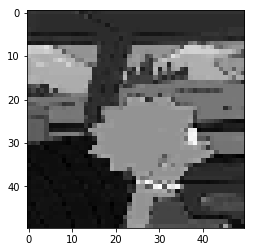

In [8]:
plt.imshow(x_img[5001], cmap="gray")

# Define Image Normalization functions

In [7]:
def max_min_normalize(x):
    # x shall have shape: n * img_W * img_H
    x  = np.float32(x)
    for i in range(x.shape[0]):
        xi = x[i]
        if (np.max(xi) == np.min(xi)):
            x[i] = (xi-np.min(xi))
        else:
            x[i] = (xi-np.min(xi))/(np.max(xi) - np.min(xi))
    return x

def divid255_normalize(x):
    # x shall have shape: n * img_W * img_H
    x  = np.float32(x)
    x /= 255
    return x


def normalize(func, x_img):
    x_ = np.array(x_img)
    func(x_)
    return x_

## Image Normalization

In [8]:
# processing data

Use_MaxMin_Normalize = True

if (Use_MaxMin_Normalize):
    func = max_min_normalize
else:
    func = divid255_normalize
    
x_ = normalize(func, x_img)

#convert to 4D array due to we shall feed 4D data to the convl2D function
x_ = x_[:,:,:,np.newaxis]
print(x_.shape)    

(7274, 50, 50, 1)


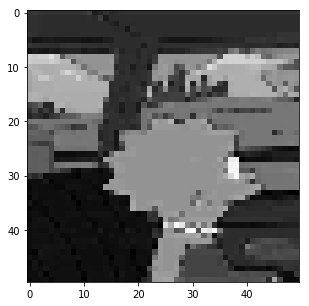

In [108]:
plt.imshow(x_img[5001], cmap="gray")

# Prepare the training and testing data

In [9]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_, simpson_y, test_size=0.1)

## record the dim of img ##
# img = img.flatten()

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
                training_shape = x_train.shape, testing_shape=x_test.shape))
print('y_ shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, testing_shape=y_test.shape))



input_data shape: training (6546, 50, 50, 1) ; testing (728, 50, 50, 1)
y_ shape: training (6546, 6) ; testing (728, 6)


# Build the NN 

In [124]:
if (1):
    dropout1 = 0.25
    dropout2 = 0.25
    dropout3 = 0.4
    dropout4 = 0.6
    # build our CNN model
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=x_train[0].shape))
    model.add(Activation('relu'))

    model.add(Conv2D(32, (5, 5)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout1))
    #------------------------------------------------

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout2))
    #------------------------------------------------

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout3))

    #------------------------------------------------
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout4))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

else:
    model = Sequential()

    model.add(Conv2D(64, (5, 5), padding='same',
                     input_shape=x_train[0].shape))
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    #------------------------------------------------

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    #------------------------------------------------

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    #------------------------------------------------

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 50, 50, 32)        832       
_________________________________________________________________
activation_49 (Activation)   (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 46, 46, 32)        25632     
_________________________________________________________________
activation_50 (Activation)   (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 23, 23, 64)        18496     
__________

# Use Keras regularizer to build NN

kernel_regularizer=regularizers.l2(0.01),
activity_regularizer=regularizers.l1(0.01)
    
    

In [142]:
from keras import regularizers
if (1):
    dropout1 = 0.25
    dropout2 = 0.25
    dropout3 = 0.4
    dropout4 = 0.6
    # build our CNN model
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=x_train[0].shape,
                     kernel_regularizer=regularizers.l2(0.01)))
#                     activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))

    model.add(Conv2D(32, (5, 5),
                     kernel_regularizer=regularizers.l2(0.01)))
#                      activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout1))
    #------------------------------------------------

    model.add(Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(0.01)))
#                      activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3),
                     kernel_regularizer=regularizers.l2(0.01)))
#                      activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout2))
    #------------------------------------------------

    model.add(Conv2D(128, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(0.01)))
#                      activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3),
                     kernel_regularizer=regularizers.l2(0.01)))
#                      activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout3))

    #------------------------------------------------
    model.add(Flatten())
    model.add(Dense(512,
                     kernel_regularizer=regularizers.l2(0.01)))
#                      activity_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(dropout4))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

else:
    model = Sequential()

    model.add(Conv2D(64, (5, 5), padding='same',
                     input_shape=x_train[0].shape))
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    #------------------------------------------------

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    #------------------------------------------------

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    #------------------------------------------------

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 50, 50, 32)        832       
_________________________________________________________________
activation_73 (Activation)   (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 46, 46, 32)        25632     
_________________________________________________________________
activation_74 (Activation)   (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 23, 23, 64)        18496     
__________

In [143]:
# initiate Adam optimizer
opt = keras.optimizers.Adam()

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Parameters setting here

In [144]:
batch_size = 32
epochs = 100
my_patience = 100

paras = 'E'+ str(epochs)+'Bs'+str(batch_size)+'P'+str(my_patience)
print(paras)
model_name = 'keras_simpsonCNN_model'+ paras +'.h5'
history_name = 'trainHistoryDict'+ paras
print(model_name)
print(history_name)

E100Bs32P100
keras_simpsonCNN_modelE100Bs32P100.h5
trainHistoryDictE100Bs32P100


# Methods for saving training history
## use the flag Save_History_To_File = True to save history file  

In [145]:
import pickle

Save_History_To_File = False

def saveHistory(model_history, history_name):
    if (save_history_to_file):
        with open(history_name, 'wb') as file_pi:
            pickle.dump(model_history, file_pi)
    
def loadHistory(history_name):
    if (save_history_to_file):
        model_history = pickle.load(open(history_name, mode='rb'))
        return model_history
    else:
        return None


# Set Checkpoint and EarlyStop function

In [146]:

print('Using real-time data augmentation.')

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True, 
    vertical_flip=False)


# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=my_patience, verbose=1)


Using real-time data augmentation.


# Fit the model with a small epochs first to check our model is good or not
### we remove the checkpoint callback because checkpoint function now will usually cause system hang....have no idea about this issue now....

In [147]:
small_epochs = 20
# Fit the model on the batches generated by datagen.flow().
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=small_epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4,
                                    callbacks=[earlystop])

saveHistory(model_history, history_name)
        

Epoch 1/20
205/205 [==============================] - 3s 16ms/step - loss: 15.6855 - acc: 0.3069 - val_loss: 13.3200 - val_acc: 0.3063
Epoch 2/20
205/205 [==============================] - 2s 12ms/step - loss: 9.3485 - acc: 0.2933 - val_loss: 2.6732 - val_acc: 0.3063
Epoch 3/20
205/205 [==============================] - 2s 12ms/step - loss: 2.2785 - acc: 0.3075 - val_loss: 1.9946 - val_acc: 0.3063
Epoch 4/20
205/205 [==============================] - 2s 12ms/step - loss: 1.8895 - acc: 0.3091 - val_loss: 1.7826 - val_acc: 0.3063
Epoch 5/20
205/205 [==============================] - 2s 11ms/step - loss: 1.7512 - acc: 0.3091 - val_loss: 1.6942 - val_acc: 0.3063
Epoch 6/20
205/205 [==============================] - 2s 11ms/step - loss: 1.6931 - acc: 0.3090 - val_loss: 1.6551 - val_acc: 0.3063
Epoch 7/20
205/205 [==============================] - 2s 12ms/step - loss: 1.6634 - acc: 0.3092 - val_loss: 1.6374 - val_acc: 0.3063
Epoch 8/20
205/205 [==============================] - 2s 12ms/step 

# Fit the model by using all the epochs

In [130]:
epochs = 200
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4,
                                    callbacks=[earlystop])

saveHistory(model_history, history_name)



Epoch 1/200
205/205 [==============================] - 2s 12ms/step - loss: 1.5089 - acc: 0.3692 - val_loss: 1.4790 - val_acc: 0.3736
Epoch 2/200
205/205 [==============================] - 2s 10ms/step - loss: 1.4881 - acc: 0.3837 - val_loss: 1.4206 - val_acc: 0.4505
Epoch 3/200
205/205 [==============================] - 2s 10ms/step - loss: 1.4851 - acc: 0.3813 - val_loss: 1.3667 - val_acc: 0.4643
Epoch 4/200
205/205 [==============================] - 2s 11ms/step - loss: 1.4840 - acc: 0.3895 - val_loss: 1.4125 - val_acc: 0.4382
Epoch 5/200
205/205 [==============================] - 2s 11ms/step - loss: 1.4465 - acc: 0.4122 - val_loss: 1.5434 - val_acc: 0.3407
Epoch 6/200
205/205 [==============================] - 2s 12ms/step - loss: 1.4323 - acc: 0.4131 - val_loss: 1.3477 - val_acc: 0.4629
Epoch 7/200
205/205 [==============================] - 2s 11ms/step - loss: 1.4096 - acc: 0.4327 - val_loss: 1.3747 - val_acc: 0.4231
Epoch 8/200
205/205 [==============================] - 2s 11ms

# Show the traing loss and acc in images

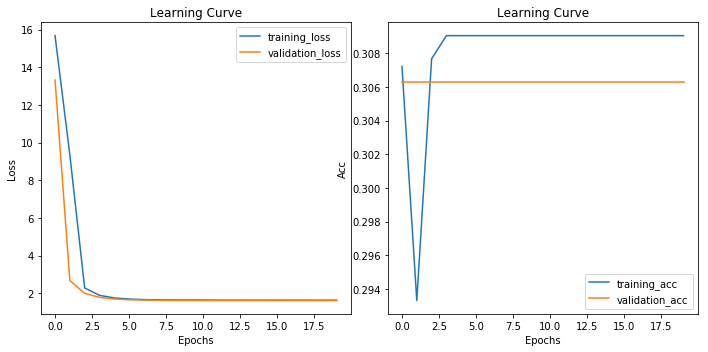

In [148]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5


model_history = model_history.history

training_loss = model_history['loss']
val_loss = model_history['val_loss']
training_acc = model_history['acc']
val_acc = model_history['val_acc']


plot_dict = {1:121, 2:122}

plt.subplot(plot_dict[1])
plt.tight_layout()
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')


plt.subplot(plot_dict[2])
plt.tight_layout()
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')


plt.show()


# load the training_Model

In [121]:
# loading our save model
print("Loading trained model")
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

Loading trained model


OSError: Unable to open file (unable to open file: name = '/home/jovyan/MyCourse/0223_tensorflow_cnn/session4_cnn_in_keras/saved_models/keras_simpsonCNN_modelE100Bs32P100.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Verify the testing-data

In [132]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

728/728 [==============================] - 0s 109us/step
Test loss: 0.955641379068
Test accuracy: 0.656593406593


# load the training model history if need

In [89]:

model_history = loadHistory(history_name)
if (model_history == None):
    print("The file is not existed\n")
else:
    print(model_history.history.keys())

The file is not existed

